# Prepare the data

###### Define root directory for data.
This directory should already contain the test.zip and train.zip files from Kaggle.

In [1]:
DATA_PATH = "/home/gzpjpk/data/dog-breed-identification"

In [2]:
from utils import *
from vgg16 import Vgg16
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


###### Unzip labels

In [3]:
!unzip $DATA_PATH/labels.csv.zip -d $DATA_PATH > /dev/null

###### Unzip data downloaded from Kaggle into `test/` and `train/` folders.

In [4]:
!unzip $DATA_PATH/train.zip -d $DATA_PATH > /dev/null
!unzip $DATA_PATH/test.zip -d $DATA_PATH > /dev/null

In [5]:
!mkdir    $DATA_PATH/valid
!mkdir    $DATA_PATH/results

!mkdir -p $DATA_PATH/sample/train
!mkdir    $DATA_PATH/sample/test
!mkdir    $DATA_PATH/sample/valid
!mkdir    $DATA_PATH/sample/results

mkdir: cannot create directory ‘/home/gzpjpk/data/dog-breed-identification/results’: File exists


###### Create validation dataset

In [6]:
g = glob(DATA_PATH + '/train/*.jpg')
shuf = np.random.permutation(g)
for filepath in shuf[:2000]:
    os.rename(filepath, DATA_PATH+'/valid/' + os.path.basename(filepath))

###### Copy out some sample data

In [7]:
from shutil import copyfile

def copyNFromTo(n, src, dest):
    g = glob(src + '/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(n):
        filepath = shuf[i]
        copyfile(filepath, dest + '/' + os.path.basename(filepath))

        
copyNFromTo(500, DATA_PATH+'/train', DATA_PATH+'/sample/train')
copyNFromTo(100,  DATA_PATH+'/valid', DATA_PATH+'/sample/valid')
copyNFromTo(100,  DATA_PATH+'/test',  DATA_PATH+'/sample/test' )

###### Move  images into separate  directories for labels

In [8]:
import csv
allLabels = { row['breed'] for row in csv.DictReader(open(DATA_PATH + '/labels.csv', 'rb')) }

def get_label_for_image(filepath):
    name, ext = os.path.splitext(os.path.basename(filepath))
    for row in csv.DictReader(open(DATA_PATH+'/labels.csv')):
        if name == row['id']:
            return row['breed']
    raise Exception('Did not find filename match in labels CSV file ' + name)

def separateByLabel(dir):
    for label in allLabels: os.makedirs(dir + '/' + label)
    for filepath in glob(dir + '/*.jpg'):
        label = get_label_for_image(filepath)
        filename = os.path.basename(filepath)
        os.rename(filepath, dir + '/' + label + '/' + filename)

separateByLabel(DATA_PATH + '/train')
separateByLabel(DATA_PATH + '/valid')
separateByLabel(DATA_PATH + '/sample/train')
separateByLabel(DATA_PATH + '/sample/valid')

###### Move test images into unknown folder

In [9]:
def moveToUnknown(base_path):
    os.makedirs(base_path + '/unknown')
    for filepath in glob(base_path+'/*.jpg'):
        filename = os.path.basename(filepath)
        os.rename(filepath, base_path + '/unknown/' + filename)

moveToUnknown(DATA_PATH + '/test')
moveToUnknown(DATA_PATH + '/sample/test')

# Train VGG16 Neural Net

In [10]:
#path = DATA_PATH + '/sample' # use sample data
path = DATA_PATH # use real data

vgg = Vgg16()
batches = vgg.get_batches(path+'/train', batch_size=64)
val_batches = vgg.get_batches(path+'/valid', batch_size=128)
vgg.finetune(batches)

Found 8222 images belonging to 120 classes.
Found 2000 images belonging to 120 classes.


In [11]:
latest_weights_filename = None

In [12]:
no_of_epochs = 10

for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(DATA_PATH + '/results/' + latest_weights_filename) # saving weights after each epoch
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
8222/8222 [==============================] - 311s - loss: 3.2749 - acc: 0.4370 - val_loss: 1.2109 - val_acc: 0.6890
Running epoch: 1
Epoch 1/1
8222/8222 [==============================] - 312s - loss: 1.5927 - acc: 0.6591 - val_loss: 1.2886 - val_acc: 0.7110
Running epoch: 2
Epoch 1/1
8222/8222 [==============================] - 311s - loss: 1.2222 - acc: 0.7222 - val_loss: 1.3099 - val_acc: 0.7150
Running epoch: 3
Epoch 1/1
8222/8222 [==============================] - 312s - loss: 1.0452 - acc: 0.7587 - val_loss: 1.3416 - val_acc: 0.7135
Running epoch: 4
Epoch 1/1
8222/8222 [==============================] - 312s - loss: 0.9162 - acc: 0.7881 - val_loss: 1.5213 - val_acc: 0.6980
Running epoch: 5
Epoch 1/1
8222/8222 [==============================] - 311s - loss: 0.8073 - acc: 0.8106 - val_loss: 1.4653 - val_acc: 0.7195
Running epoch: 6
Epoch 1/1
8222/8222 [==============================] - 311s - loss: 0.7197 - acc: 0.8269 - val_loss: 1.4767 - val_acc: 0.7180

# Generate Predictions

In [22]:
batch_size = 64
batches, preds = vgg.test(path+'/test', batch_size = batch_size*2)

Found 10357 images belonging to 1 classes.


Try to manually verify the column ordering

In [23]:
print preds[:5]
print batches.filenames[:5]

[[  3.4100e-10   2.4721e-06   6.6931e-10   8.9605e-05   2.3726e-06   1.2454e-05   3.9377e-08
    2.8360e-07   4.8107e-07   1.1320e-03   2.1058e-06   2.2429e-09   2.2528e-07   7.6544e-10
    6.1213e-11   6.5703e-04   3.3408e-05   8.7584e-10   6.5313e-04   7.2911e-12   3.6320e-12
    2.9175e-10   4.8284e-11   9.6900e-11   1.1351e-02   8.0265e-09   9.7247e-11   1.3166e-05
    6.2808e-08   7.1356e-08   4.2302e-13   3.9343e-11   4.0457e-08   6.9093e-06   3.6983e-08
    1.4299e-10   2.7585e-13   1.5598e-09   3.7425e-09   2.6694e-01   7.6429e-04   1.6611e-06
    5.8574e-08   2.7399e-06   4.5300e-08   1.5366e-12   8.1727e-05   3.3752e-05   8.2156e-10
    4.0201e-07   7.6342e-08   7.2081e-05   3.0330e-07   5.8917e-07   6.8008e-10   1.9910e-07
    1.0828e-11   1.2352e-06   9.8144e-10   5.1673e-05   1.4948e-02   9.9025e-09   2.9182e-14
    1.9043e-05   9.9548e-10   1.9109e-11   5.9207e-04   2.5954e-06   2.9681e-05   1.7367e-10
    6.6560e-08   6.8133e-09   8.0084e-09   1.4027e-08   2.3327e-09   2

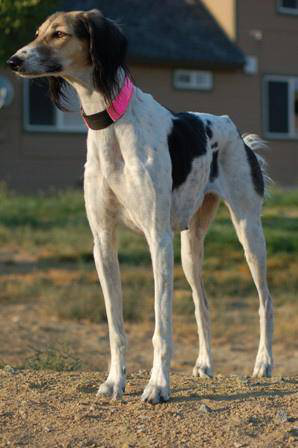

In [24]:
from PIL import Image
Image.open(path + '/test/' + batches.filenames[0])

Save test results arrays

In [25]:
save_array(path + '/results/test_preds.dat', preds)
save_array(path + '/results/filenames.dat', batches.filenames)

# Validate Predictions

In [17]:
# vgg.model.load_weights(DATA_PATH + '/results/ft___.h5')

In [18]:
# val_batches, probs = vgg.test(DATA_PATH + '/valid', batch_size = 64)

In [19]:
# expected_labels = val_batches.classes 

##Round our predictions to 0/1 to generate labels
## our_predictions = probs[:,0]
## our_labels = np.round(1-our_predictions)

In [20]:
#from keras.preprocessing import image
#
##Helper function to plot images by index in the validation set 
##Plots is a helper function in utils.py
#def plots_idx(idx, titles=None):
#    plots([image.load_img(DATA_PATH + '/valid/' + val_batches.filenames[i]) for i in idx], titles=titles)
#    
##Number of images to view for each visualization task
#n_view = 4

In [21]:
# #1. A few correct labels at random
# correct = np.where(our_labels==expected_labels)[0]
# print "Found %d correct labels" % len(correct)
# idx = permutation(correct)[:n_view]
# plots_idx(idx, our_predictions[idx])